In [73]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

In [100]:
#load data
categories = ['comp.graphics', 'comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories,  shuffle=True,random_state=42)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories,  shuffle=True,random_state=42)

In [3]:
#check keys, how many different categories
train_dataset.keys(),np.unique(train_dataset['target'])

(dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description']),
 array([0, 1, 2, 3, 4, 5, 6, 7]))

Text(0.5,0,'number of training documents')

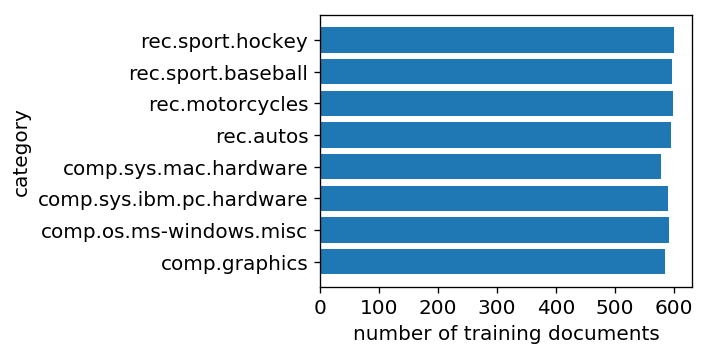

In [4]:
#plot histogram
plt.figure(figsize=(4,3),dpi=120)
plt.hist(train_dataset['target'],bins=np.arange(9)-0.5,orientation='horizontal',align='mid',rwidth=0.8)
plt.yticks(np.unique(train_dataset['target']),train_dataset['target_names'],fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('category',fontsize=12)
plt.xlabel('number of training documents',fontsize=12)

In [75]:
#pre-process docs into 'bag of words'
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import text
import nltk
from nltk import pos_tag
#nltk.download()
#nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
#nltk.download('averaged_perceptron_tagger')

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'
    
# lemmatize with Parts of Speech (POS) tags
wnl = nltk.wordnet.WordNetLemmatizer()
def lemmatize(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) for word, tag in pos_tag(list_word)]

In [101]:
# create custom analyzer remove_num, incoporating the above lemmatizer
analyze = CountVectorizer().build_analyzer()  #default analyzer, process text into words with default settings
remove_num=lambda doc: [word for word in lemmatize(analyze(doc)) if not word.isdigit()]
remove_num_no_lemma=lambda doc: [word for word in analyze(doc) if not word.isdigit()]

#create vectorizer with the above analyzer, vectorize and tfidf_transform
vectorizer=CountVectorizer(min_df=3,analyzer=remove_num, stop_words='english')
tfidf_transformer = TfidfTransformer(smooth_idf=False)  #smoothing is for test data that contain unseen terms?
#fit and transform on train data
X_train=vectorizer.fit_transform(train_dataset['data'])
X_train_tfidf=tfidf_transformer.fit_transform(X_train)
#only do transform on test data
X_test_tfidf=tfidf_transformer.transform(vectorizer.transform(test_dataset['data']))
#get the shape of matrics, #docs * #terms
X_train_tfidf.shape,X_test_tfidf.shape

((4732, 16600), (3150, 16600))

In [6]:
#compare nltk.word_tokenize() and CountVectorizer().build_analyzer()
test="Hello, how're you? I was better today."
a=nltk.word_tokenize(test)
b=CountVectorizer(min_df=0, stop_words=None).build_analyzer()(test)
print(a, b)
print(lemmatize(a), lemmatize(b))

['Hello', ',', 'how', "'re", 'you', '?', 'I', 'was', 'better', 'today', '.'] ['hello', 'how', 're', 'you', 'was', 'better', 'today']
['hello', ',', 'how', "'re", 'you', '?', 'i', 'be', 'well', 'today', '.'] ['hello', 'how', 're', 'you', 'be', 'good', 'today']


In [102]:
#dimension reduction: NMF
from sklearn.decomposition import NMF
nmf = NMF(n_components=50, init='random', random_state=0)
W_train = nmf.fit_transform(X_train_tfidf)
H_train = nmf.components_
error_nmf=nmf.reconstruction_err_

#dimension reduction: LSI
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
X_train_reduced = svd.fit_transform(X_train_tfidf)
X_train_recon=svd.inverse_transform(X_train_reduced)
from numpy import linalg as LA
error_svd=LA.norm(X_train_tfidf-X_train_recon)

error_nmf,error_svd

(62.84403289515657, 62.48150498540807)

NMF has larger mean squared residual because it has a stronger non-negative constraint which sacrifices reconstruction accuracy for more interpretability.

In [103]:
#map tp comp:1  rec:-1
y_train=np.ones(len(train_dataset['target']))
y_train[np.where(train_dataset['target']>=4)]=-1

y_test=np.ones(len(test_dataset['target']))
y_test[np.where(test_dataset['target']>=4)]=-1

#check 
np.unique(np.array(train_dataset['target'])[np.where(y_train==1)])

array([0, 1, 2, 3])

In [79]:
from sklearn.svm import SVC
svc_hard,svc_soft=SVC(C=1000,kernel='linear'),SVC(C=0.0001,kernel='linear')
svc_hard.fit(X_train_reduced,y_train)
svc_soft.fit(X_train_reduced,y_train)
score_hard,score_soft=svc_hard.decision_function(X_train_reduced),svc_soft.decision_function(X_train_reduced)

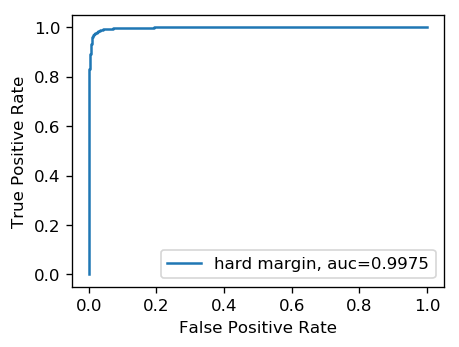

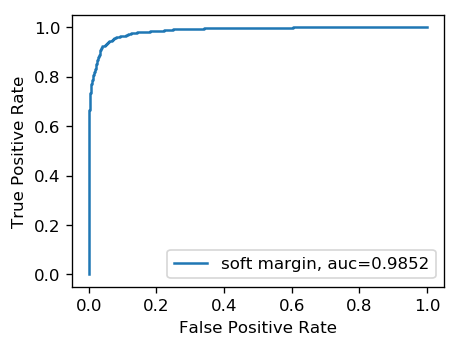

In [80]:
from sklearn import metrics
def plot_roc_curve(y_train,scores,label):
    fpr, tpr, t = metrics.roc_curve(y_train, scores)
    plt.figure(figsize=(4,3),dpi=120)
    plt.plot(fpr,tpr,label=label+ ', auc={:.4f}'.format(metrics.auc(fpr,tpr)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

plot_roc_curve(y_train,score_hard,'hard margin')
plot_roc_curve(y_train,score_soft,'soft margin')

In [81]:
# tn,fp
# fn,tp
cm_h=metrics.confusion_matrix(y_train,svc_hard.predict(X_train_reduced))
cm_s=metrics.confusion_matrix(y_train,svc_soft.predict(X_train_reduced))
def evaluate_clf(cm):
    tn,fp,fn,tp=cm[0,0],cm[0,1],cm[1,0],cm[1,1]
    accuracy=(tp+tn)/np.sum(cm)
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    f1=2/(1/recall+1/precision)
    return tn,fp,fn,tp,accuracy,recall,precision,f1

report_scores= lambda cm:  print ('hard margin SVC, tn={:},fp={:},fn={:},tp={:},\
 accuracy={:.4f},recall={:.4f},precision={:.4f},F_1 score={:.4f}'.format(*evaluate_clf(cm)))
report_scores(cm_h)
report_scores(cm_s)

hard margin SVC, tn=2337,fp=52,fn=53,tp=2290, accuracy=0.9778,recall=0.9774,precision=0.9778,F_1 score=0.9776
hard margin SVC, tn=2389,fp=0,fn=2343,tp=0, accuracy=0.5049,recall=0.0000,precision=nan,F_1 score=nan


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


Confusion matrix, without normalization
[[2337   52]
 [  53 2290]]


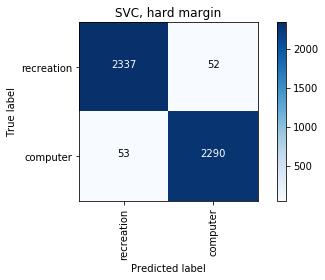

In [84]:
plot_confusion_matrix(cm_h, ['recreation','computer'],normalize=False,title='SVC, hard margin',cmap=plt.cm.Blues)

Confusion matrix, without normalization
[[2389    0]
 [2343    0]]


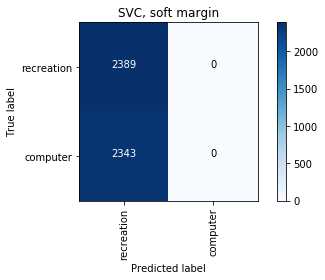

In [85]:
plot_confusion_matrix(cm_s, ['recreation','computer'],normalize=False,title='SVC, soft margin',cmap=plt.cm.Blues)

function score is the distance from hyperplane. soft margin is all negative

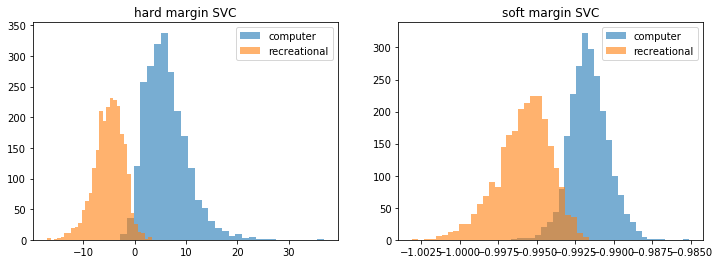

In [12]:
f,(ax1,ax2)=plt.subplots(nrows=1, ncols=2,figsize=(12,4))
ax1.hist(score_hard[np.where(y_train==1)],bins=30,alpha=0.6,label='computer')
ax1.hist(score_hard[np.where(y_train==-1)],bins=30,alpha=0.6,label='recreational')
ax1.set(title='hard margin SVC')
ax1.legend()
ax2.hist(score_soft[np.where(y_train==1)],bins=30,alpha=0.6,label='computer')
ax2.hist(score_soft[np.where(y_train==-1)],bins=30,alpha=0.6,label='recreational')
ax2.set(title='soft margin SVC')
ax2.legend()

Confusion matrix, without normalization
[[2336   53]
 [  53 2290]]


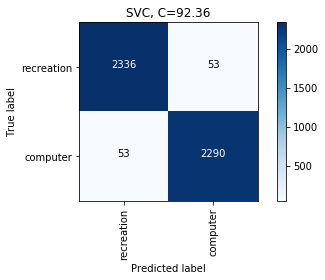

In [105]:
sss=SVC(C=92.36,kernel='linear')
sss.fit(X_train_reduced,y_train)
ppp=sss.predict(X_train_reduced)
cmppp=metrics.confusion_matrix(y_train,ppp)
plot_confusion_matrix(cmppp, ['recreation','computer'],normalize=False,title='SVC, C=92.36')


In [106]:
report_scores(cmppp)

hard margin SVC, tn=2336,fp=53,fn=53,tp=2290, accuracy=0.9776,recall=0.9774,precision=0.9774,F_1 score=0.9774


hard margin SVC, tn=2336,fp=53,fn=52,tp=2291, accuracy=0.9778,recall=0.9778,precision=0.9774,F_1 score=0.9776
hard margin SVC, tn=760,fp=830,fn=176,tp=1384, accuracy=0.6806,recall=0.8872,precision=0.6251,F_1 score=0.7334


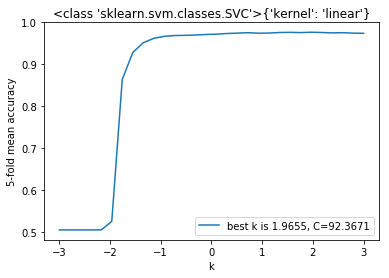

In [87]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
X_test_reduced = svd.fit_transform(X_test_tfidf)
def best_param(model,kargs):
    k_list=np.linspace(-3,3,30)
    scores=[]
    for k in k_list:
        C=10**k
        clf=model(C=C,**kargs)
        # f1_macro: http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
        scores.append(np.mean(cross_val_score(clf, X_train_reduced, y_train, 
                                              cv=KFold(5,shuffle=True,random_state=42), scoring='accuracy')))
    k_best=k_list[np.argmax(np.array(scores))]
    plt.plot(np.linspace(-3,3,30),scores,label='best k is {:.4f}, C={:.4f}'.format(k_best, 10**k_best))
    plt.xlabel('k')
    plt.ylabel('5-fold mean accuracy')
    plt.legend()
    plt.title(str(model)+str(kargs))
    
    clf=model(C=10**k_best,**kargs)
    clf.fit(X_train_reduced,y_train)
    cm_train=metrics.confusion_matrix(y_train,clf.predict(X_train_reduced))
    cm_test=metrics.confusion_matrix(y_test,clf.predict(X_test_reduced))
    report_scores(cm_train)
    report_scores(cm_test)

model=SVC  #class object is not callable
kargs={'kernel':'linear'}
best_param(model,kargs)

hard margin SVC, tn=2336,fp=53,fn=51,tp=2292, accuracy=0.9780,recall=0.9782,precision=0.9774,F_1 score=0.9778
hard margin SVC, tn=766,fp=824,fn=188,tp=1372, accuracy=0.6787,recall=0.8795,precision=0.6248,F_1 score=0.7306


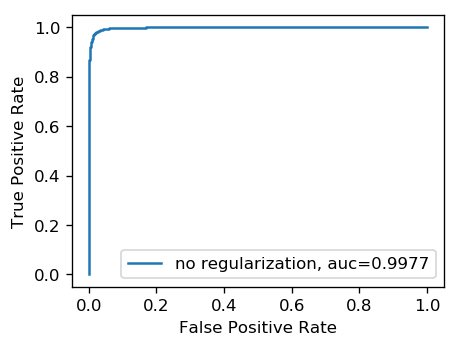

In [88]:
from sklearn.linear_model import LogisticRegression as LR
lr_no=LR(penalty='l2',C=1e10)
lr_no.fit(X_train_reduced,y_train)
scores_lr_no=lr_no.decision_function(X_train_reduced)
pred_lr_no=lr_no.predict(X_train_reduced)
cm_lr_no=metrics.confusion_matrix(y_train,pred_lr_no)
report_scores(cm_lr_no)
plot_roc_curve(y_train,scores_lr_no,'no regularization')

pred_lr_no_test=lr_no.predict(X_test_reduced)
cm_lr_no_test=metrics.confusion_matrix(y_test,pred_lr_no_test)
report_scores(cm_lr_no_test)

Confusion matrix, without normalization
[[2336   53]
 [  51 2292]]


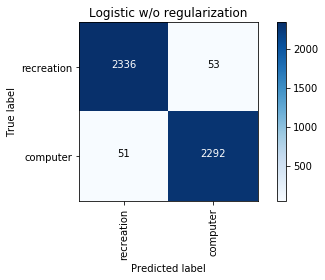

In [89]:
plot_confusion_matrix(cm_lr_no, ['recreation','computer'],normalize=False,title='Logistic w/o regularization',cmap=plt.cm.Blues)

Train, tn=2337, fp=52, fn=52, tp=2291, accuracy=0.9780, recall=0.9778, precision=0.9778, f1=0.9778
Test, tn=767, fp=823, fn=177, tp=1383, accuracy=0.6825, recall=0.8865, precision=0.6269, f1=0.7345


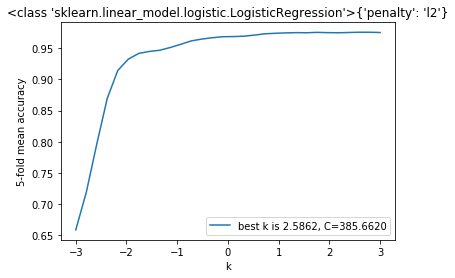

In [20]:
model=LR  #class object is not callable
kargs={'penalty':'l2'}
best_param(model,kargs)

Train, tn=2334, fp=55, fn=52, tp=2291, accuracy=0.9774, recall=0.9778, precision=0.9766, f1=0.9772
Test, tn=764, fp=826, fn=138, tp=1422, accuracy=0.6940, recall=0.9115, precision=0.6326, f1=0.7468


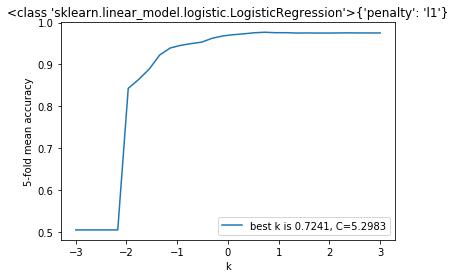

In [21]:
model=LR  #class object is not callable
kargs={'penalty':'l1'}
best_param(model,kargs)

There are 2 differences to note:

Logistic loss diverges faster than hinge loss. So, in general, it will be more sensitive to outliers.

Logistic loss does not go to zero even if the point is classified sufficiently confidently. This might lead to minor degradation in accuracy.

So, you can typically expect SVM to perform marginally better than logistic regression.

with a dataset favoring overfitting, the regularized models perform much better

In the case of Gauss prior we don’t get sparse coefficients, but smaller coefficients than without regularization. In other words, Gauss leads to smaller values in general, while Laplace leads to sparse coefficient vectors with a few higher values

Regularization can lead to better model performance
Different prior options impact the coefficients differently. Where Gauss generally leads to smaller coefficients, Laplace results in sparse coefficient vectors with just a few higher value coefficients.

hard margin SVC, tn=2317,fp=72,fn=351,tp=1992, accuracy=0.9106,recall=0.8502,precision=0.9651,F_1 score=0.9040
hard margin SVC, tn=866,fp=724,fn=387,tp=1173, accuracy=0.6473,recall=0.7519,precision=0.6183,F_1 score=0.6786


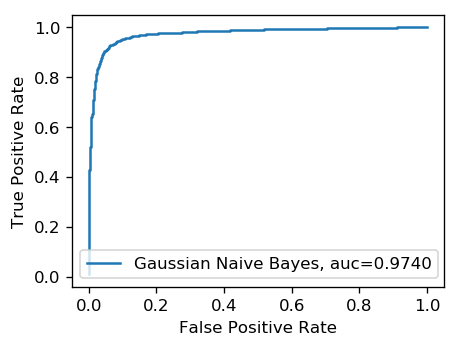

In [90]:
from sklearn.naive_bayes import GaussianNB as GNB
gnb=GNB()
gnb.fit(X_train_reduced,y_train)
scores_gnb=gnb.predict_log_proba(X_train_reduced)[:,1]
pred_gnb_train=gnb.predict(X_train_reduced)
pred_gnb_test=gnb.predict(X_test_reduced)
cm_gnb_train=metrics.confusion_matrix(y_train,pred_gnb_train)
cm_gnb_test=metrics.confusion_matrix(y_test,pred_gnb_test)
report_scores(cm_gnb_train)
report_scores(cm_gnb_test)
plot_roc_curve(y_train,scores_gnb,'Gaussian Naive Bayes')

Confusion matrix, without normalization
[[2317   72]
 [ 351 1992]]


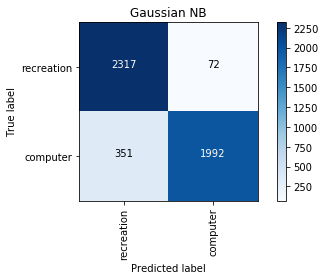

In [92]:
plot_confusion_matrix(metrics.confusion_matrix(y_train,pred_gnb_train), ['recreation','computer'],normalize=False,title='Gaussian NB',cmap=plt.cm.Blues)

In [57]:
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression as LR
from sklearn.naive_bayes import GaussianNB as GNB
from sklearn.pipeline import Pipeline
# create custom analyzer remove_num
analyze = CountVectorizer().build_analyzer()  #default analyzer, process text into words with default settings
def remove_num(doc): 
    return [word for word in lemmatize(analyze(doc)) if not word.isdigit()]  #w/ lemmatize
def remove_num_no_lemma(doc): 
    return [word for word in analyze(doc) if not word.isdigit()]   #w/o lemmatize

pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=remove_num, stop_words='english')),
    ('tfidf', TfidfTransformer(smooth_idf=False)),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', SVC(C=92.36,kernel='linear')),
])
#use a list of dicts if tuning clf parameters
param_grid=[{'vect__min_df':[3,5],
            'vect__analyzer':[remove_num,remove_num_no_lemma],
            'reduce_dim':[TruncatedSVD(n_components=50, random_state=0),
                          NMF(n_components=50, init='random', random_state=0)],
             'clf':[SVC(C=92.36,kernel='linear'),
                   LR(C=5.3,penalty='l1'),
                   LR(C=385.66,penalty='l2'),
                   GNB()]
            }]

from sklearn.model_selection import GridSearchCV   #split first then transform, to avoid info leak between train/test
grid = GridSearchCV(pipeline, cv=KFold(5,shuffle=True,random_state=42),
                    n_jobs=-1, param_grid=param_grid, scoring='accuracy',verbose=2,return_train_score=False)

In [46]:
categories = ['comp.graphics', 'comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles','rec.sport.baseball', 'rec.sport.hockey']
cv_columns=['param_clf', 'param_reduce_dim', 'param_vect__analyzer','param_vect__min_df', 'mean_test_score']
#load data in different ways
def loading_data(remove):
    train_dataset = fetch_20newsgroups(subset='train',remove=remove,
                                       categories = categories,shuffle=True,random_state=42)
    test_dataset = fetch_20newsgroups(subset='test',remove=remove,
                                      categories = categories,shuffle=True,random_state=42)
    #specify x
    X_train=train_dataset['data']
    X_test=test_dataset['data']
    #map to comp:1  rec:-1
    y_train=np.ones(len(train_dataset['target']))
    y_train[np.where(train_dataset['target']>=4)]=-1
    y_test=np.ones(len(test_dataset['target']))
    y_test[np.where(test_dataset['target']>=4)]=-1
    return X_train,X_test,y_train,y_test

In [78]:
%%time
#not remove headers/footers
remove=()
X_train,X_test,y_train,y_test=loading_data(remove)
grid.fit(X_train,y_train)
print(np.mean(grid.predict(X_test)==y_test))
import pandas as pd
results=pd.DataFrame(grid.cv_results_)[cv_columns]
results.to_csv('not remove headers.csv')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] clf=SVC(C=92.36, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=0, tol=0.0), vect__analyzer=<function remove_num at 0x1a27b28bf8>, vect__min_df=3 
[CV] clf=SVC(C=92.36, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=0, tol=0.0), vect__analyzer=<function remove_num at 0x1a27b28bf8>, vect__min_df=3 
[CV] clf=SVC(C=92.36, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', deg

  solver='cd', tol=0.0001, verbose=0), vect__analyzer=<function remove_num at 0x1a27b28bf8>, vect__min_df=3, total= 3.5min
[CV] clf=LogisticRegression(C=5.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=0, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vect__analyzer=<function remove_num at 0x1a27b28bf8>, vect__min_df=3 
[CV]  clf=LogisticRegression(C=5.3, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.

  solver='cd', tol=0.0001, verbose=0), vect__analyzer=<function remove_num at 0x1a27b28bf8>, vect__min_df=3 
[CV]  clf=LogisticRegression(C=385.66, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=0, tol=0.0), vect__analyzer=<function remove_num at 0x1a27b28bf8>, vect__min_df=3, total= 2.6min
[CV] clf=LogisticRegression(C=385.66, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=0, shuffle=False,


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 46.1min


[CV]  clf=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=0, tol=0.0), vect__analyzer=<function remove_num at 0x1a27b28bf8>, vect__min_df=3, total= 2.6min
[CV] clf=GaussianNB(priors=None), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=0, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vect__analyzer=<function remove_num at 0x1a27b28bf8>, vect__min_df=3 
[CV]  clf=GaussianNB(priors=None), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=0, tol=0.0), vect__analyzer=<function remove_num at 0x1a27b28bf8>, vect__min_df=3, total= 2.6min
[CV] clf=GaussianNB(priors=None), reduce_dim=NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components=50, random_state=0, shuffle=False,
  solver='cd', tol=0.0001, verbose=0), vect__analyzer=<function remove_num at 0x1a27b

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 52.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer=<function remove_num at 0x1a27b28bf8>, binary=False,
        decode_error='strict', dtype=<class 'numpy.int64'>,
        encoding='utf-8', input='content', lowercase=True, max_df=1.0,
        max_features=None, min_df=3, ngram_range=(1, 1), preprocessor=None,...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'vect__min_df': [3], 'vect__analyzer': [<function remove_num at 0x1a27b28bf8>], 'reduce_dim': [TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=0, tol=0.0), NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0,
  max_iter=200, n_components...,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), GaussianNB(priors=None)]}],

In [47]:
%%time
#remove headers/footers
remove=('headers','footers')
X_train,X_test,y_train,y_test=loading_data(remove)
grid.fit(X_train,y_train)
print(np.mean(grid.predict(X_test)==y_test))
results=pd.DataFrame(grid.cv_results_)[cv_columns]
results.to_csv('remove headers_2.csv')

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] clf=SVC(C=92.36, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=0, tol=0.0), vect__analyzer=<function remove_num at 0x1a0e2edf28>, vect__min_df=3 
[CV] clf=SVC(C=92.36, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), reduce_dim=TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=0, tol=0.0), vect__analyzer=<function remove_num at 0x1a0e2edf28>, vect__min_df=3 
[CV] clf=SVC(C=92.36, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', d

       random_state=0, tol=0.0), vect__analyzer=<function remove_num_no_lemma at 0x1a0e288378>, vect__min_df=3 


KeyboardInterrupt: 

In [51]:
result_1=pd.read_csv('not remove headers.csv')
result_2=pd.read_csv('remove headers.csv')
result_all=pd.concat([result_1,result_2])[['param_clf', 'param_reduce_dim', 'param_vect__analyzer',
                                           'param_vect__min_df','mean_fit_time','mean_test_score']]
result_all.sort_values(by='mean_test_score',inplace=True,ascending=False)
result_all.reset_index(drop=True,inplace=True)
result_all

,param_clf,param_reduce_dim,param_vect__analyzer,param_vect__min_df,mean_fit_time,mean_test_score
0,"SVC(C=92.36, cache_size=200, class_weight=None...","TruncatedSVD(algorithm='randomized', n_compone...",<function remove_num at 0x000001FBE904DD90>,3,281.953489,0.976543
1,"LogisticRegression(C=5.3, class_weight=None, d...","TruncatedSVD(algorithm='randomized', n_compone...",<function remove_num at 0x000001FBE904DD90>,3,119.215585,0.976543
2,"LogisticRegression(C=385.66, class_weight=None...","TruncatedSVD(algorithm='randomized', n_compone...",<function remove_num at 0x000001FBE904DD90>,3,110.951114,0.976120
3,"SVC(C=92.36, cache_size=200, class_weight=None...","TruncatedSVD(algorithm='randomized', n_compone...",<function remove_num at 0x000001FBE904DD90>,5,263.688606,0.975909
4,"LogisticRegression(C=5.3, class_weight=None, d...","TruncatedSVD(algorithm='randomized', n_compone...",<function remove_num at 0x000001FBE904DD90>,5,109.872530,0.975909
5,"LogisticRegression(C=385.66, class_weight=None...","TruncatedSVD(algorithm='randomized', n_compone...",<function remove_num at 0x000001FBE904DD90>,5,109.470761,0.975063
6,"LogisticRegression(C=5.3, class_weight=None, d...","TruncatedSVD(algorithm='randomized', n_compone...",<function remove_num_no_lemma at 0x000001FBE90...,5,8.152935,0.973795
7,"LogisticRegression(C=385.66, class_weight=None...","TruncatedSVD(algorithm='randomized', n_compone...",<function remove_num_no_lemma at 0x000001FBE90...,3,8.023809,0.972950
8,"SVC(C=92.36, cache_size=200, class_weight=None...","TruncatedSVD(algorithm='randomized', n_compone...",<function remove_num_no_lemma at 0x000001FBE90...,5,9.152747,0.972739
9,"SVC(C=92.36, cache_size=200, class_weight=None...","TruncatedSVD(algorithm='randomized', n_compone...",<function remove_num_no_lemma at 0x000001FBE90...,3,18.826039,0.972527


In [93]:
categories_new=['comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','misc.forsale','soc.religion.christian']
train= fetch_20newsgroups(subset='train',categories = categories_new,shuffle=True,random_state=42)
test= fetch_20newsgroups(subset='test',categories = categories_new,shuffle=True,random_state=42)
X_train,y_train,X_test,y_test=train['data'],train['target'],test['data'],test['target']

In [99]:
from sklearn.svm import LinearSVC as LSVC
clf_list=[GNB(),SVC(C=92.36,kernel='linear',decision_function_shape='ovo'),
          LSVC(C=92.36,multi_class='ovr')]
from sklearn import metrics
cm_list=[]
for clf in clf_list:
    pipeline = Pipeline([
    ('vect', CountVectorizer(min_df=3, analyzer=remove_num, stop_words='english')),
    ('tfidf', TfidfTransformer(smooth_idf=False)),
    ('reduce_dim', TruncatedSVD(random_state=0)),
    ('clf', clf)
    ])
    pipeline.fit(X_train,y_train)
    y_test_pred=pipeline.predict(X_test)
    cm_list.append(metrics.confusion_matrix(y_test,y_test_pred))
    print('accuracy: {:.4f}'.format(metrics.accuracy_score(y_test,y_test_pred)),
         'recall: {:.4f}'.format(metrics.recall_score(y_test,y_test_pred,average='macro')),
         'precision: {:.4f}'.format(metrics.precision_score(y_test,y_test_pred,average='macro')),
         'f1_score: {:.4f}'.format(metrics.f1_score(y_test,y_test_pred,average='macro')))

accuracy: 0.6275 recall: 0.6263 precision: 0.6346 f1_score: 0.6079
accuracy: 0.6486 recall: 0.6471 precision: 0.6439 f1_score: 0.6330
accuracy: 0.6064 recall: 0.6025 precision: 0.5877 f1_score: 0.5374


Confusion matrix, without normalization
[[225  22 137   8]
 [211  26 135  13]
 [ 64  12 306   8]
 [  1   2   2 393]]


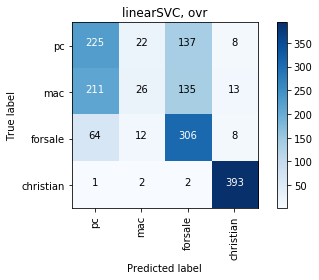

In [98]:
plot_confusion_matrix(cm_list[2], ['pc','mac','forsale','christian'],normalize=False,title='linearSVC, ovr')

In [71]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()